In [1]:
import os
import numpy as np
from tqdm import tqdm
import torch
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Data preprocessing and loading
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
}

In [4]:
data_dir = '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Train', 'Validation', 'Test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['Train', 'Validation', 'Test']}

In [5]:
# Load a pre-trained EfficientNet model
model = models.efficientnet_b0()
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [6]:
# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [7]:
# Training
train_losses, val_losses, accuracies = [], [], []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(dataloaders['Train'], desc=f'\tEpoch {epoch + 1}: Train'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(dataloaders['Train'])
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['Validation'], desc=f'\tEpoch {epoch + 1}: Valid'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels)
        val_loss /= len(dataloaders['Validation'])
        val_losses.append(val_loss.item())

    accuracy = (correct / total) * 100
    accuracies.append(accuracy)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")

	Epoch 1: Valid: 100%|██████████| 25/25 [00:06<00:00,  3.70it/s]


Epoch 1/10, Train Loss: 6.6461, Validation Loss: 6.7391, Accuracy: 7.38%


	Epoch 2: Valid: 100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Epoch 2/10, Train Loss: 6.1650, Validation Loss: 6.5457, Accuracy: 57.63%


	Epoch 3: Valid: 100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Epoch 3/10, Train Loss: 5.6650, Validation Loss: 6.2541, Accuracy: 59.50%


	Epoch 4: Valid: 100%|██████████| 25/25 [00:03<00:00,  7.66it/s]


Epoch 4/10, Train Loss: 5.1503, Validation Loss: 5.7697, Accuracy: 62.75%


	Epoch 5: Valid: 100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


Epoch 5/10, Train Loss: 4.5875, Validation Loss: 5.2620, Accuracy: 62.50%


	Epoch 6: Valid: 100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Epoch 6/10, Train Loss: 3.9628, Validation Loss: 4.2627, Accuracy: 66.88%


	Epoch 7: Valid: 100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Epoch 7/10, Train Loss: 3.3063, Validation Loss: 3.0653, Accuracy: 78.12%


	Epoch 8: Valid: 100%|██████████| 25/25 [00:03<00:00,  7.02it/s]


Epoch 8/10, Train Loss: 2.6424, Validation Loss: 2.1628, Accuracy: 83.50%


	Epoch 9: Valid: 100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Epoch 9/10, Train Loss: 2.0437, Validation Loss: 1.5804, Accuracy: 86.50%


	Epoch 10: Valid: 100%|██████████| 25/25 [00:03<00:00,  7.40it/s]

Epoch 10/10, Train Loss: 1.5631, Validation Loss: 1.1776, Accuracy: 87.00%


In [8]:
# Save the model state dictionary
torch.save(model.state_dict(), 'model_state.pth')

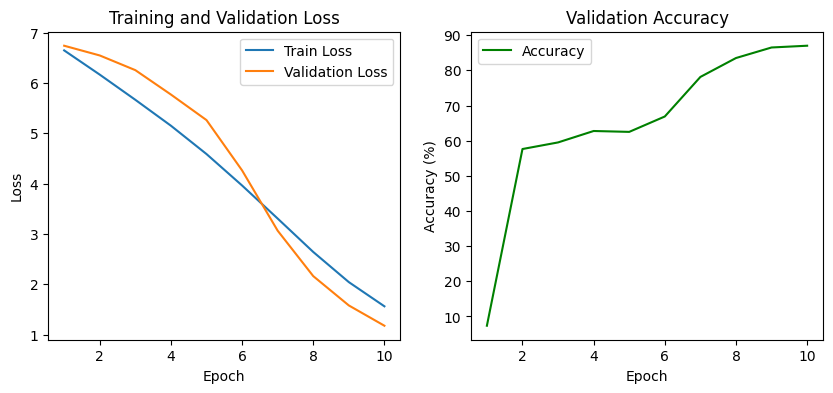

In [9]:
# Evaluation graph of accuracy and loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')

plt.show()

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


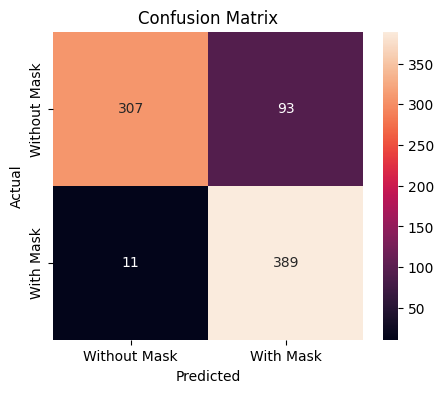

In [10]:
# Confusion Matrix
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in tqdm(dataloaders['Validation']):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=["Without Mask", "With Mask"], yticklabels=["Without Mask", "With Mask"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# Testing
model.eval()
sample_images, sample_labels = next(iter(dataloaders['Test']))
sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)

correct = 0
total = 0

with torch.no_grad():
    sample_outputs = model(sample_images)
    _, sample_predictions = torch.max(sample_outputs, 1)
    
    for inputs, labels in tqdm(dataloaders['Test']):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Testing Accuracy: {(correct / total) * 100:.2f}%')

100%|██████████| 31/31 [00:07<00:00,  4.13it/s]

Testing Accuracy: 53.43%


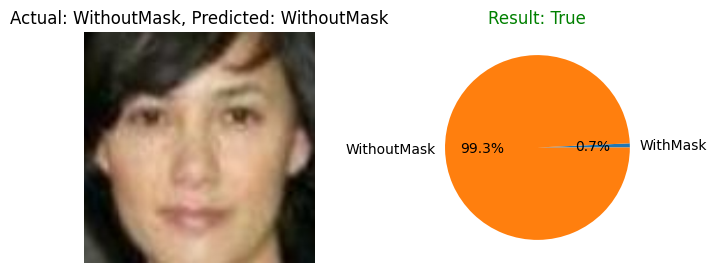

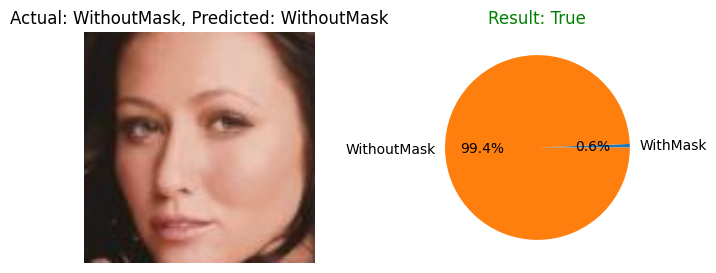

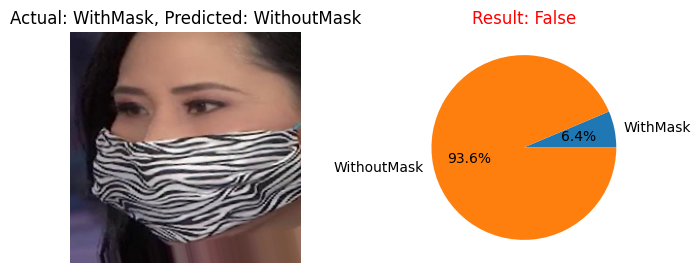

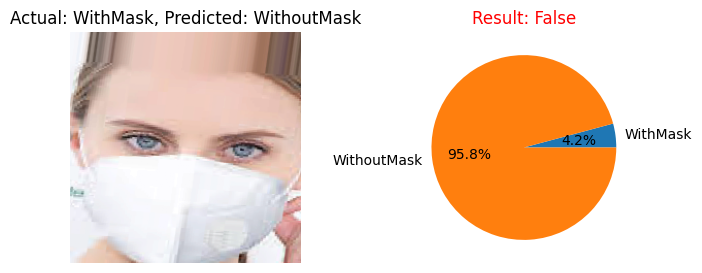

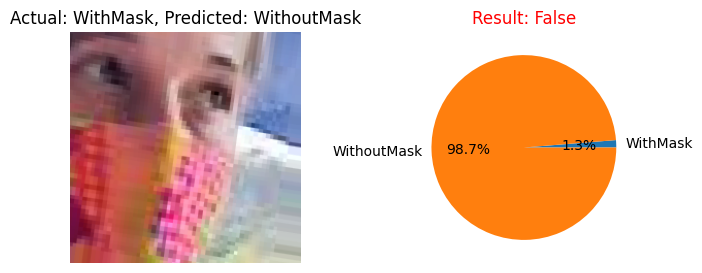

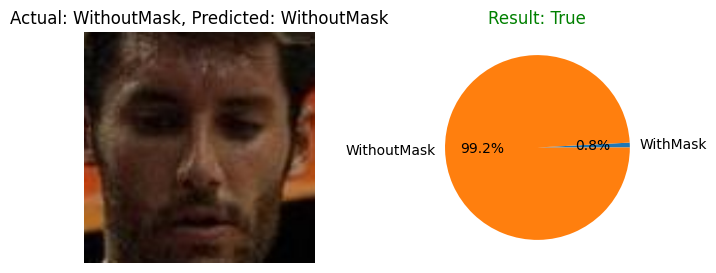

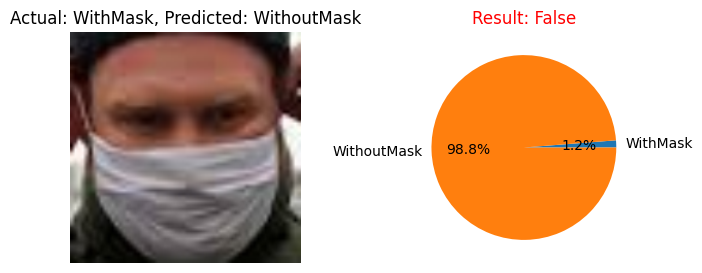

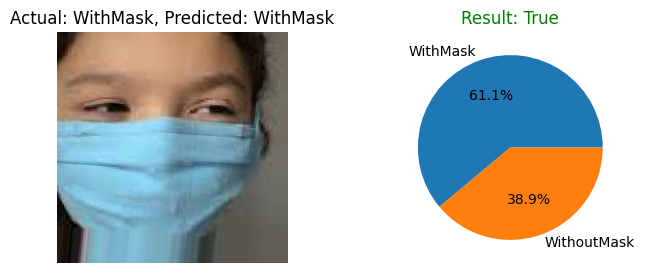

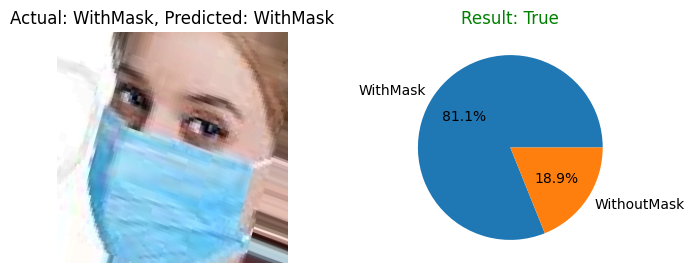

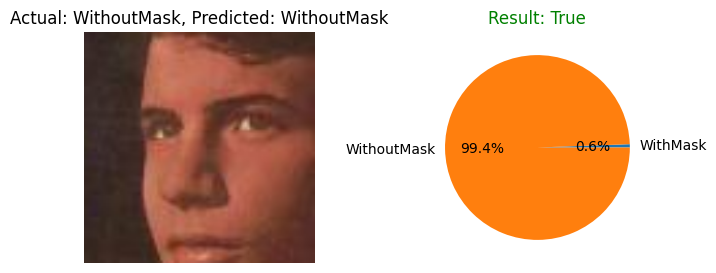

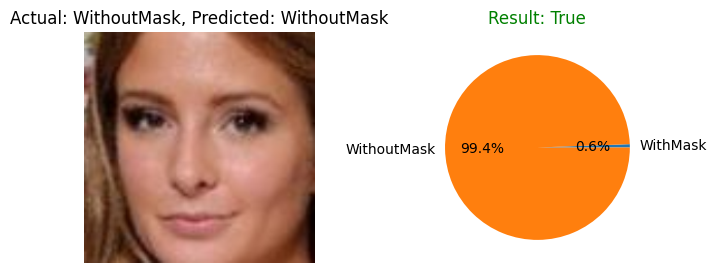

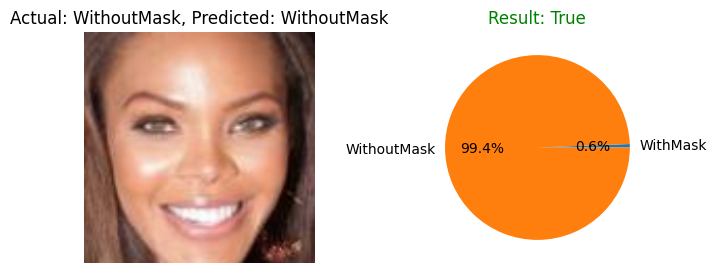

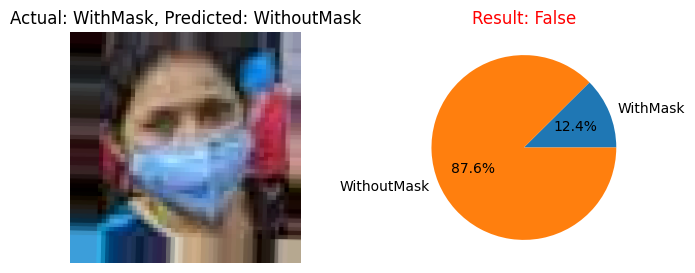

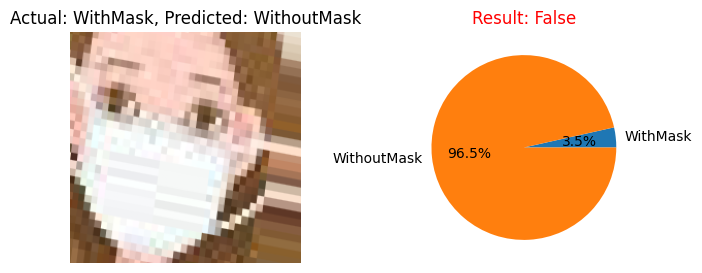

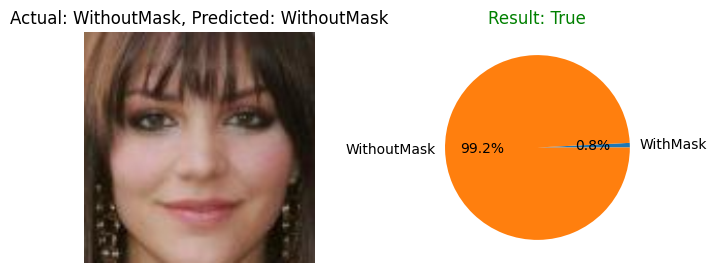

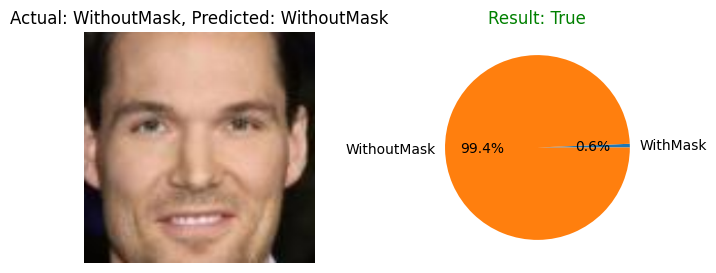

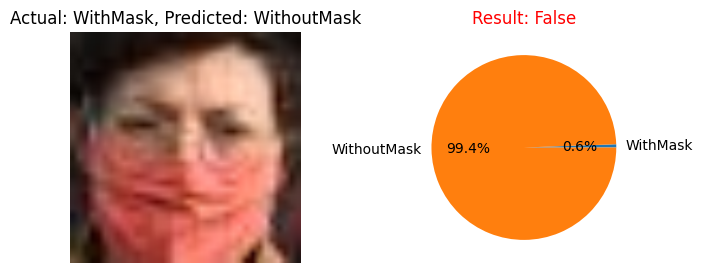

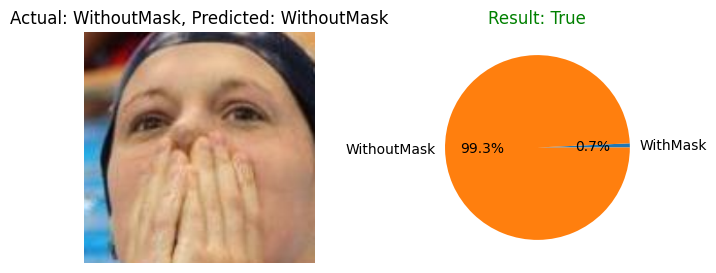

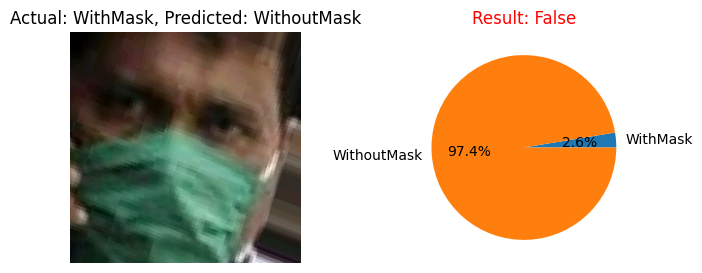

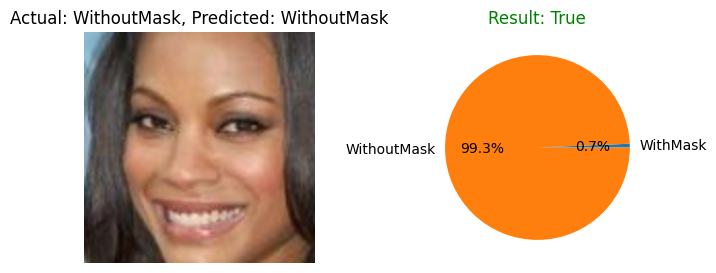

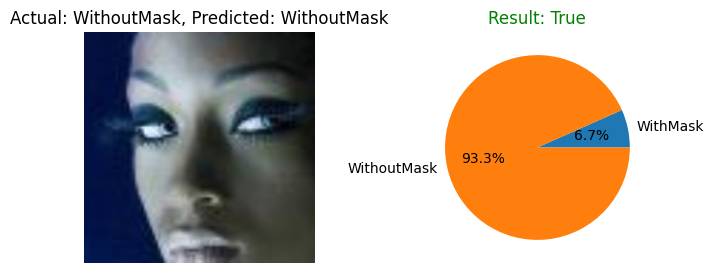

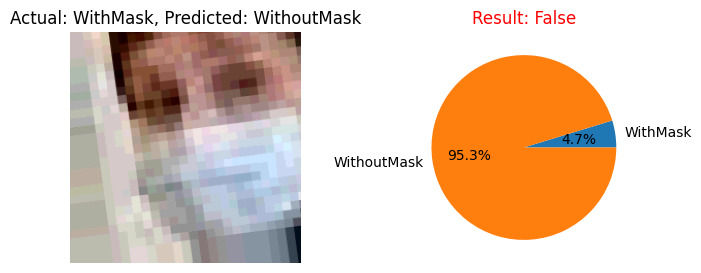

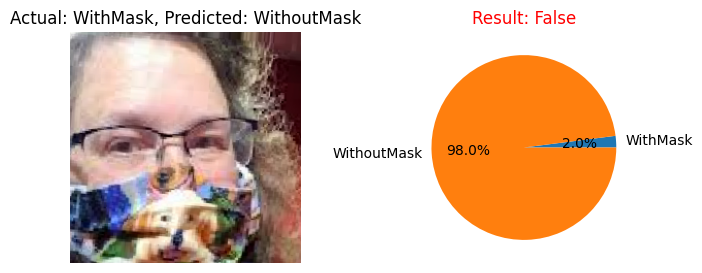

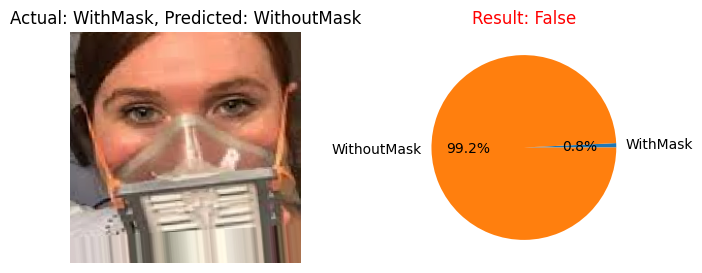

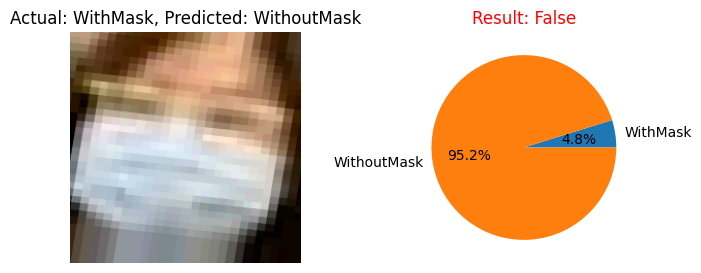

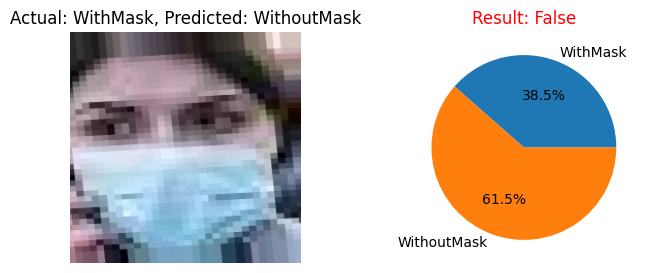

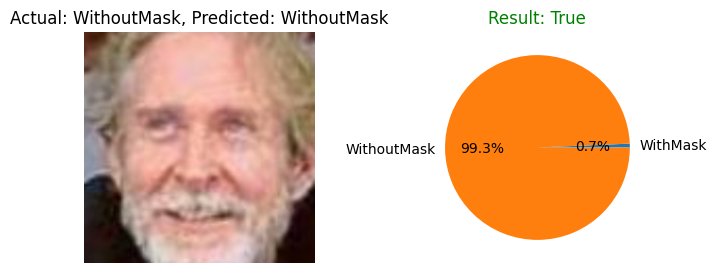

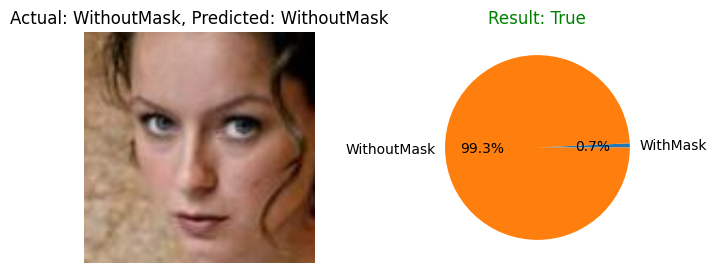

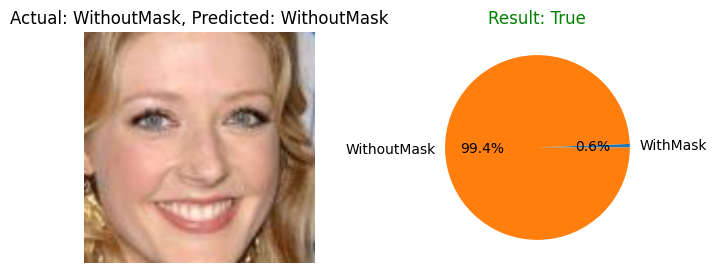

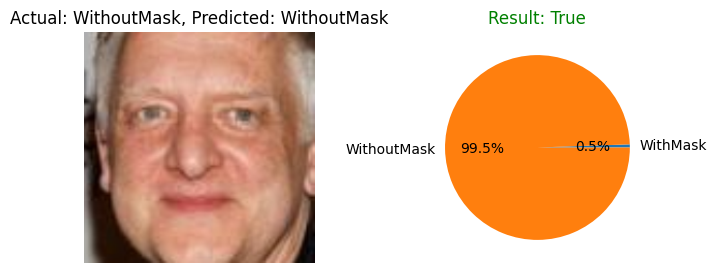

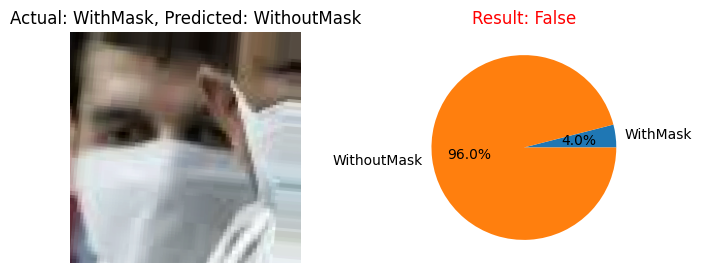

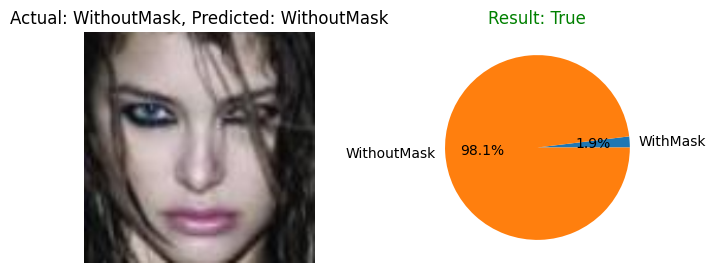

In [12]:
# Sample image prediction
class_names = image_datasets['Validation'].classes

for i in range(len(sample_images)):
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(sample_images[i].cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
    
    true_label = class_names[sample_labels[i]]
    predicted_label = class_names[sample_predictions[i]]
    result_color = 'green' if true_label == predicted_label else 'red'

    plt.title(f'Actual: {true_label}, Predicted: {predicted_label}')
    plt.subplot(1, 2, 2)

    # Extract class probabilities for the current sample
    probabilities = torch.softmax(sample_outputs[i], 0).cpu().numpy()
    class_probabilities = {class_names[j]: probabilities[j] for j in range(len(class_names))}

    # Create a pie chart to visualize class probabilities
    plt.pie(class_probabilities.values(), labels=class_probabilities.keys(), autopct='%1.1f%%')
    plt.title(f'Result: {true_label == predicted_label}', color=result_color)
    plt.show()